# Artificial Intelligence

## Lab 3: k-Nearest Neighbours & k-Means

In [1]:
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

np.random.seed(1337)

%config InlineBackend.figure_format = 'retina'

plt.rcParams = plt.rcParamsOrig

## k-Nearest Neighbours

Sebagai awal, kita akan melihat bagaimana batas keputusan dapat dibentuk dengan algoritma Nearest Neighbour. Dengan algoritma ini, Anda dapat menggambarkan [Voronoi tessellation](https://en.wikipedia.org/wiki/Voronoi_diagram).

### Voronoi Tessellation

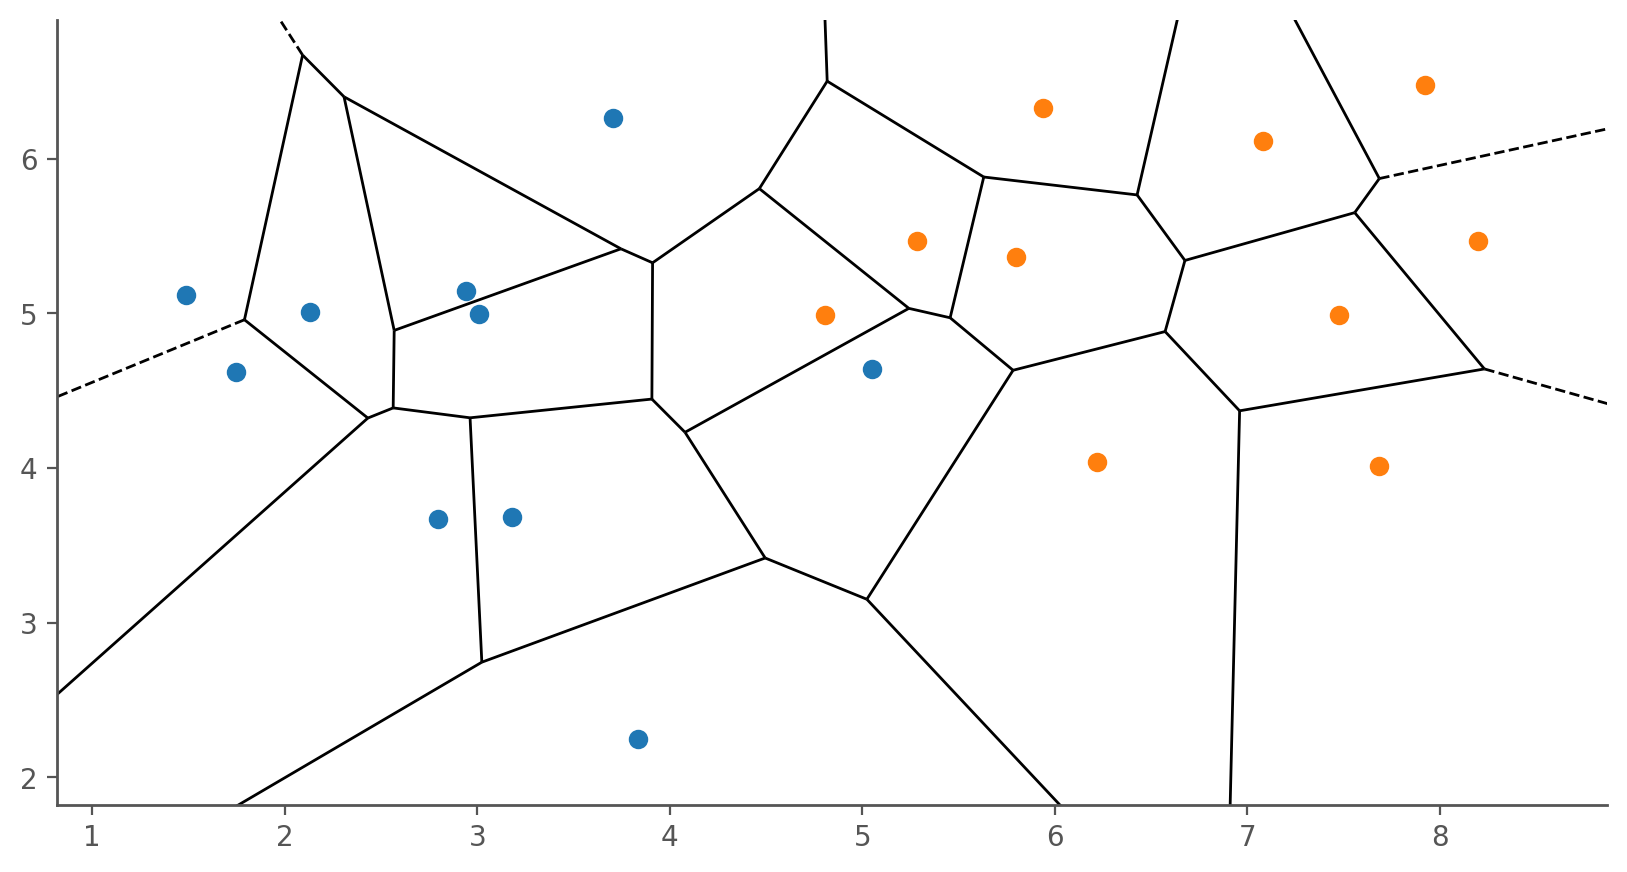

In [2]:
x1 = 3.5 + np.random.randn(10)
x2 = 6.5 + np.random.randn(10)
y1 = 5 + np.random.randn(10)
y2 = 5 + np.random.randn(10)
x = np.append(x1, x2)
y = np.append(y1, y2)

vor = Voronoi(np.array([x, y]).T)
voronoi_plot_2d(vor, show_points=False, show_vertices=False)
plt.scatter(x1, y1)
plt.scatter(x2, y2)
plt.grid(False)
plt.show()

Kita mencoba mengenalkan data baru di titik (6, 5), tetangga terdekatnya adalah titik dalam region yang sama. Dengan kata lain, Voronoi tessellation ini membentuk batas keputusan (_decision boundary_) dari algoritma Nearest Neighbour.

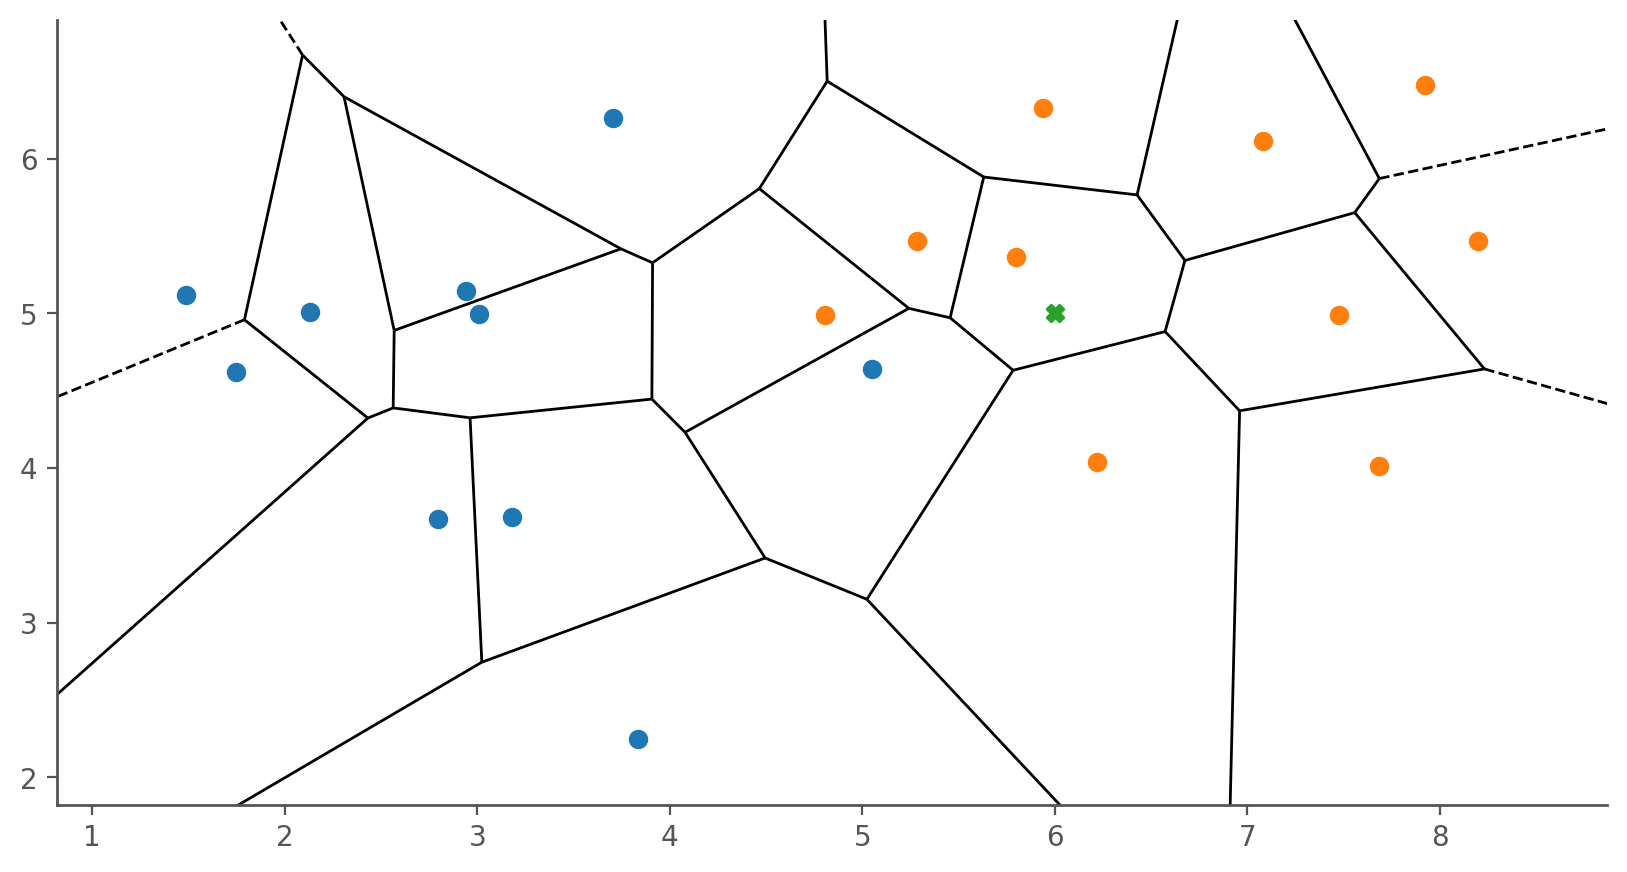

In [3]:
voronoi_plot_2d(vor, show_points=False, show_vertices=False)
plt.scatter(x1, y1)
plt.scatter(x2, y2)
plt.scatter([6], [5], marker='X')
plt.grid(False)
plt.show()

### Mencoba Berbagai Nilai k

Untuk dataset yang lebih "riil", kita akan melihat bagaimana atribut dari Pokemon dapat mempengaruhi status legendarisnya. Dataset ini diambil dari https://www.kaggle.com/abcsds/pokemon.

In [4]:
df = pd.read_csv('../datasets/pokemon.csv')
df.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


Dari dataset ini, kita akan mencoba untuk menjalankan algoritma k-NN untuk nilai $k=[1,7]$ pada data latih. Berapa menurut Anda nilai $k$ yang terbaik yang akan didapatkan?

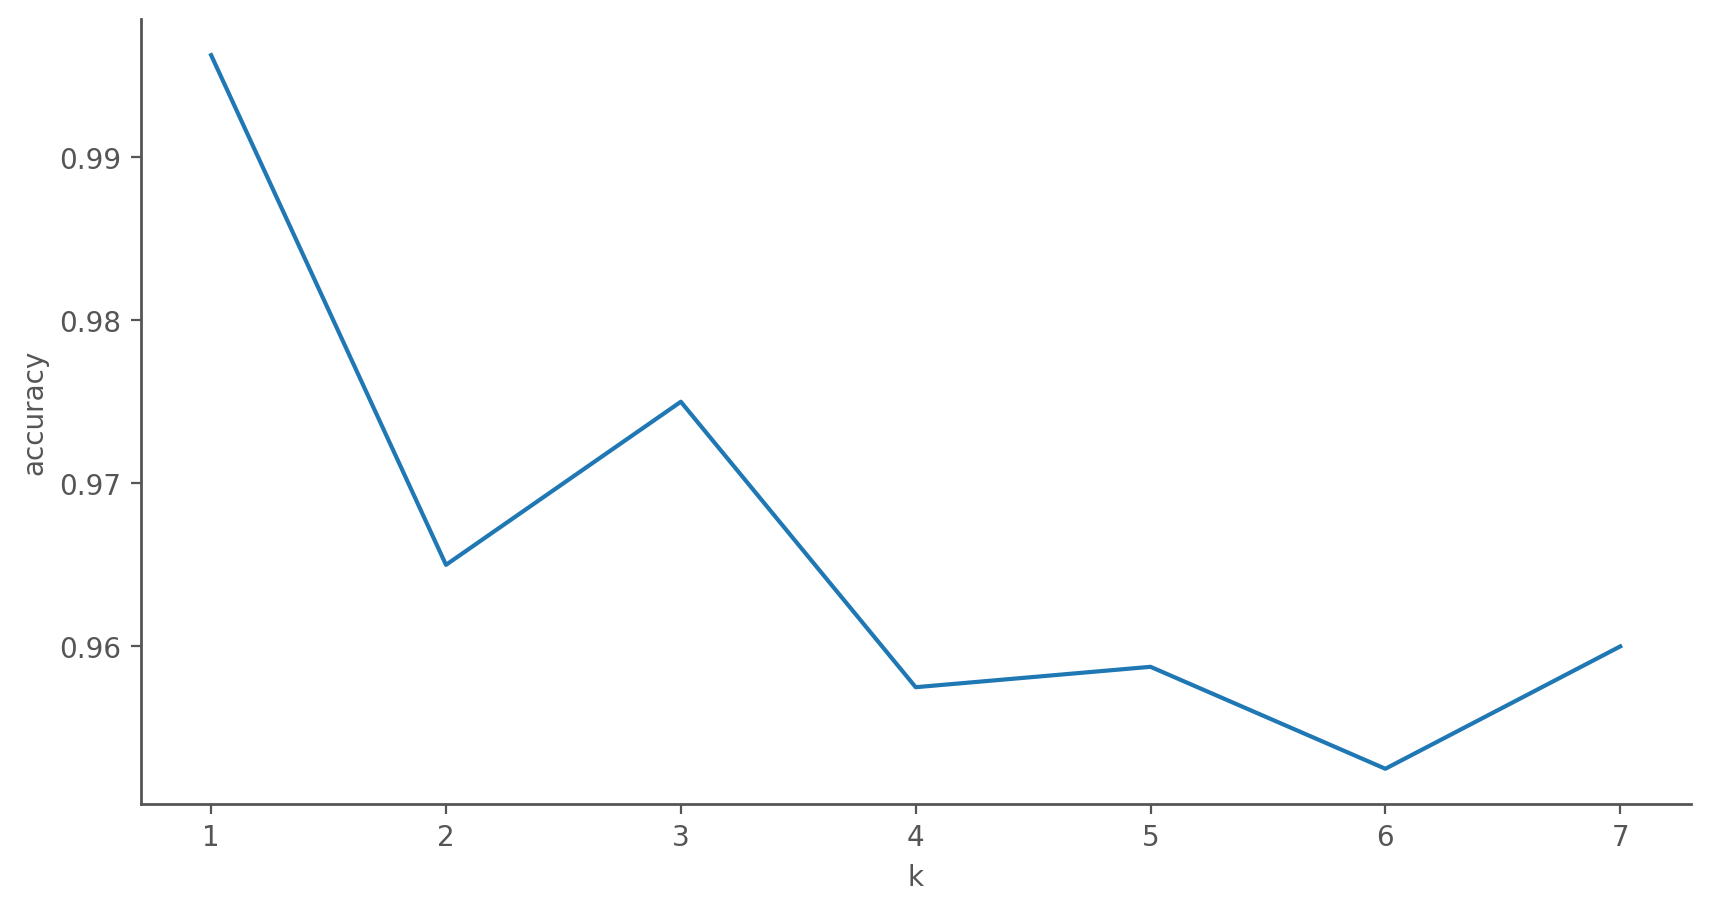

In [5]:
from sklearn.metrics import accuracy_score

X = df[['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']]
y = df['Legendary']

acc = []
for k in range(1,8):
    knn = KNeighborsClassifier(k)
    knn.fit(X, y)
    y_pred = knn.predict(X)
    acc.append(accuracy_score(y, y_pred))

plt.plot(range(1,8), acc)
plt.xlabel('k')
plt.ylabel('accuracy');

Ternyata, hasil dengan menggunakan 1-NN adalah yang terbaik. Mengapa? Apakah ini cara yang tepat untuk melakukan klasifikasi?

### Regresi dengan k-NN

k-NN juga dapat digunakan untuk regresi. Perhatikan *scatter plot* di bawah ini.

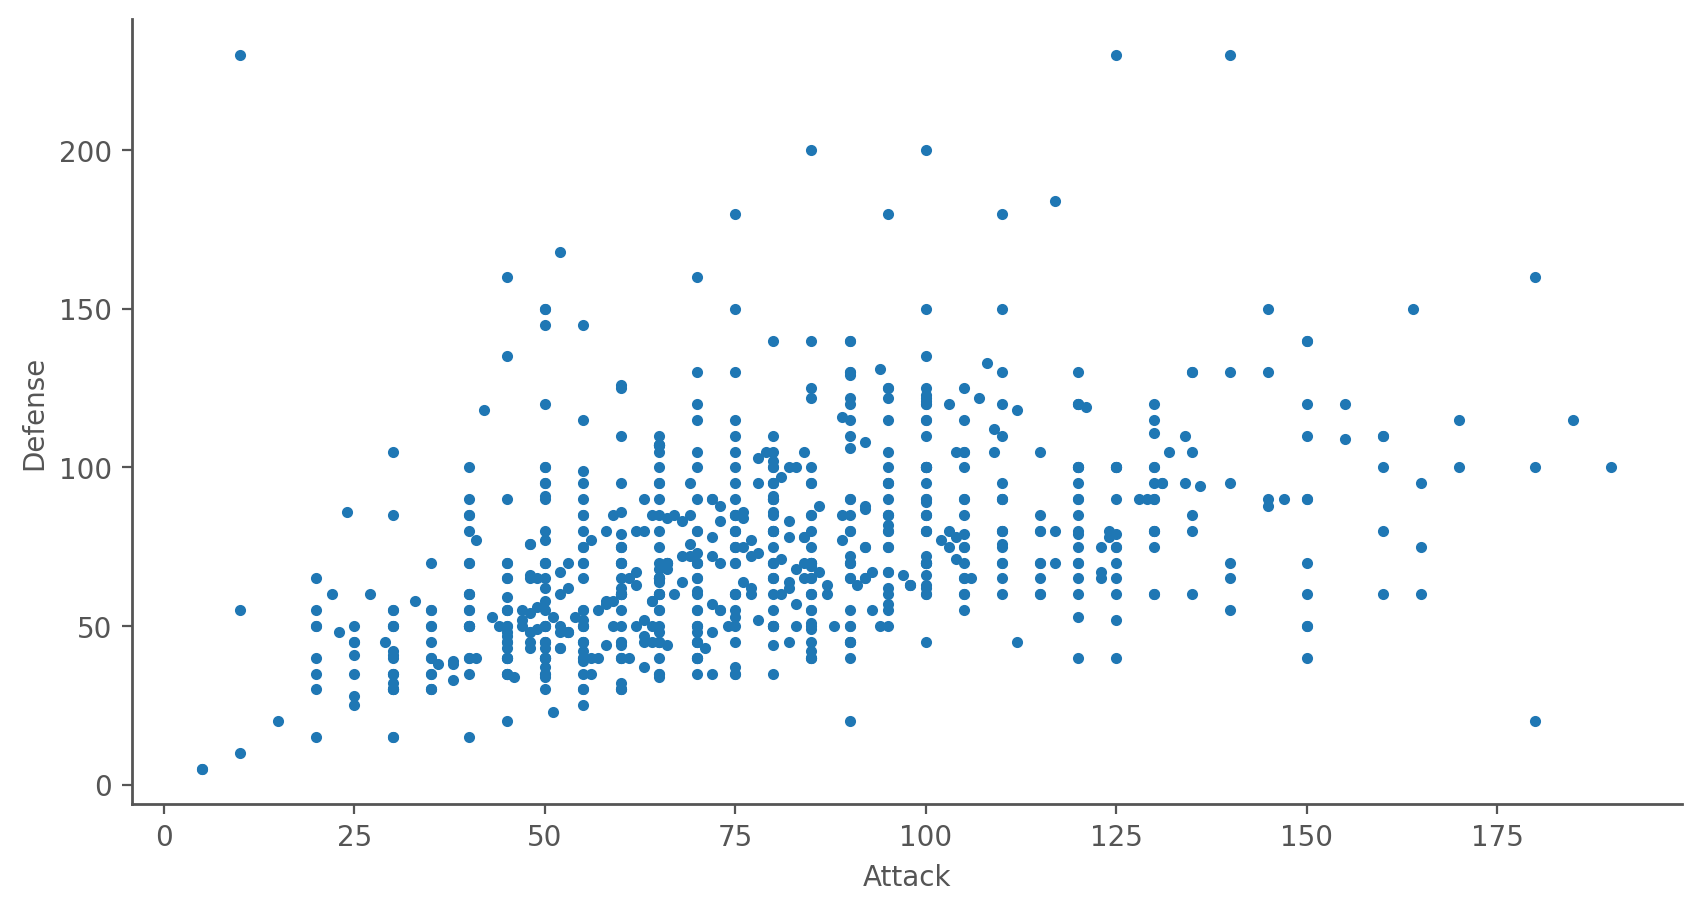

In [6]:
plt.scatter(df['Attack'], df['Defense'], marker='.')
plt.xlabel('Attack')
plt.ylabel('Defense');

Nilai `Defense` untuk dari nilai `Attack` suatu Pokemon dapat diestimasi dengan
$$
\hat{y} = \frac{1}{k} \sum_{j=1}^{k} y_{ij}
$$
Misalnya, diberikan satu data baru yang akan kita estimasi seperti di bawah ini.

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(df[['Attack']], df['Defense'], test_size=0.3, random_state=42)

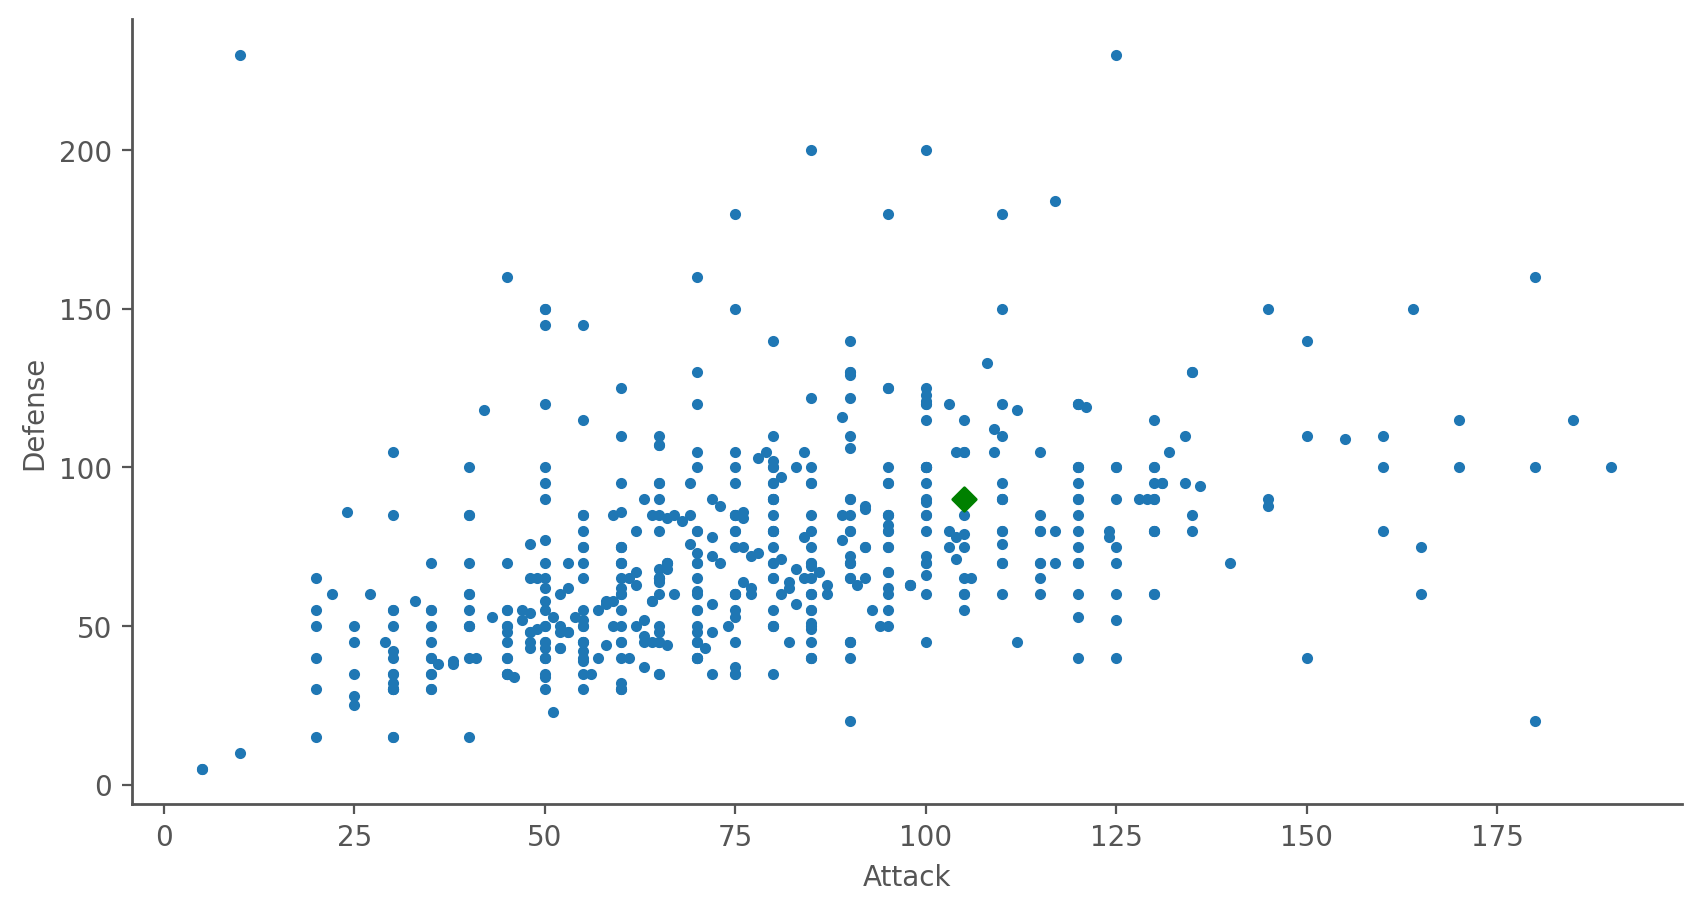

In [8]:
plt.scatter(X_train, y_train, marker='.')
plt.scatter(X_test[:1], y_test[:1], marker='D', color='g')
plt.xlabel('Attack')
plt.ylabel('Defense');

Dari beberapa nilai $k$, ternyata 1-NN menghasilkan regresi yang paling dekat dengan nilai sebenarnya yang digambarkan dengan tanda wajik hijau.

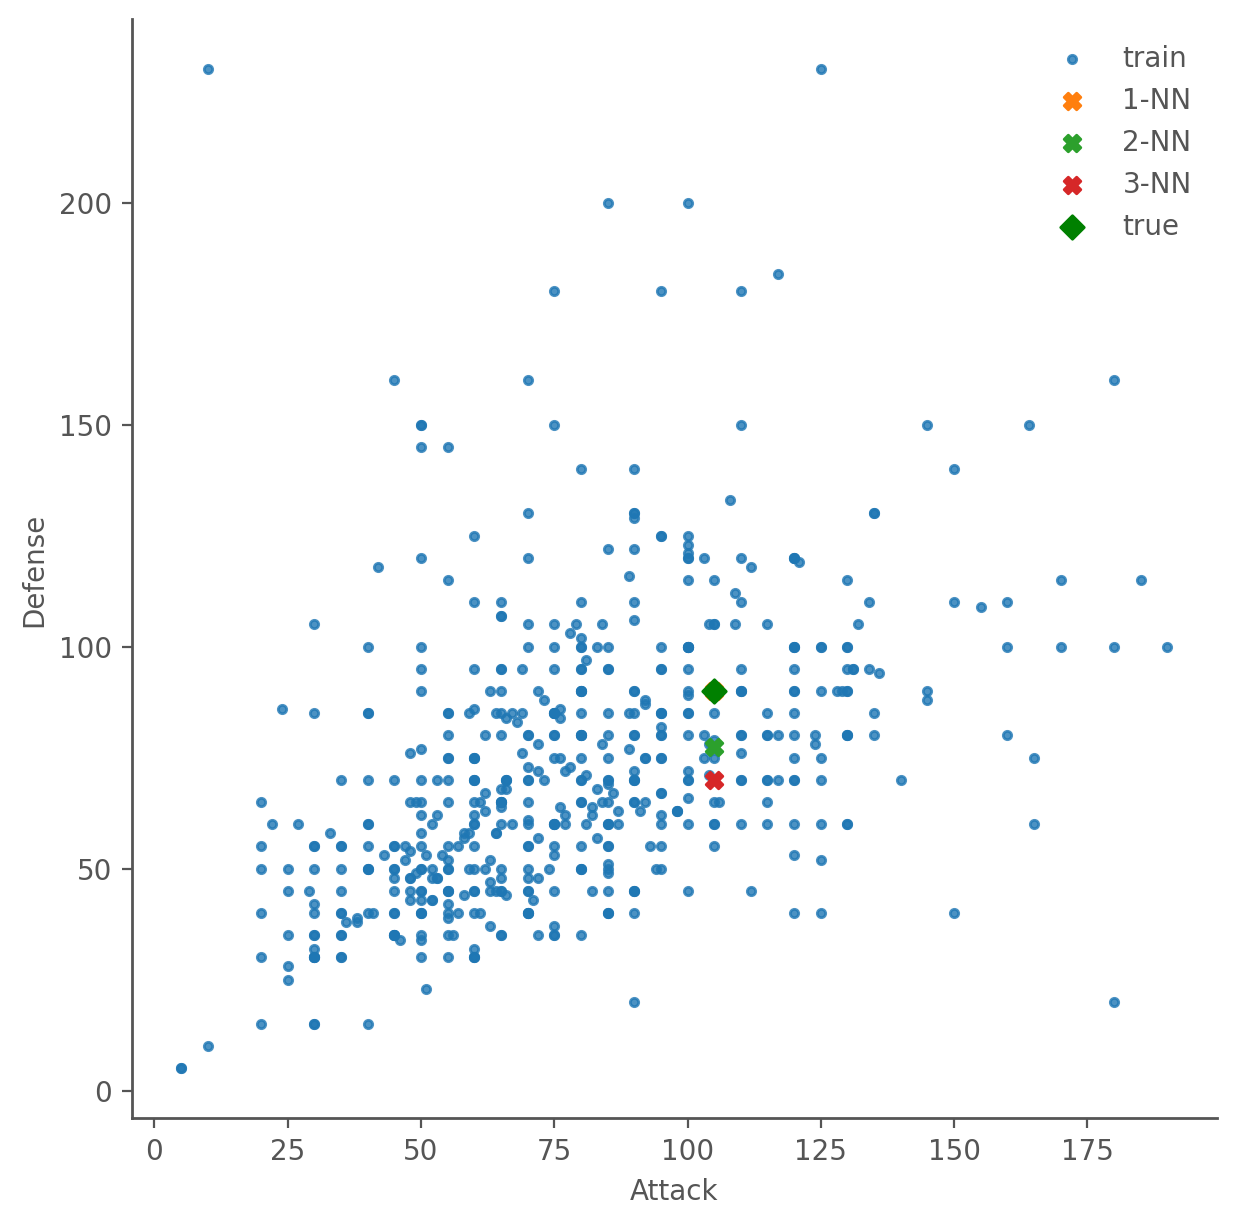

In [9]:
from sklearn.neighbors import KNeighborsRegressor

fig, ax = plt.subplots(figsize=(7,7))
mse = []
ax.scatter(X_train, y_train, marker='.', alpha=.8, label='train')
for k in range(1,4):
    knr = KNeighborsRegressor(k)
    knr.fit(X_train, y_train)
    y_pred = knr.predict(X_test[:1])
    ax.scatter(X_test[:1], y_pred, label='%d-NN' % k, marker='X')
ax.scatter(X_test[:1], y_test[:1], label='true', marker='D', color='g')
plt.legend()
plt.xlabel('Attack')
plt.ylabel('Defense');

Akan tetapi, saat dievaluasi dengan menggunakan semua data uji, ternyata *mean squared error* (MSE) terendah justru didapatkan dengan 10-NN. Mengapa hasilnya bisa berbeda?

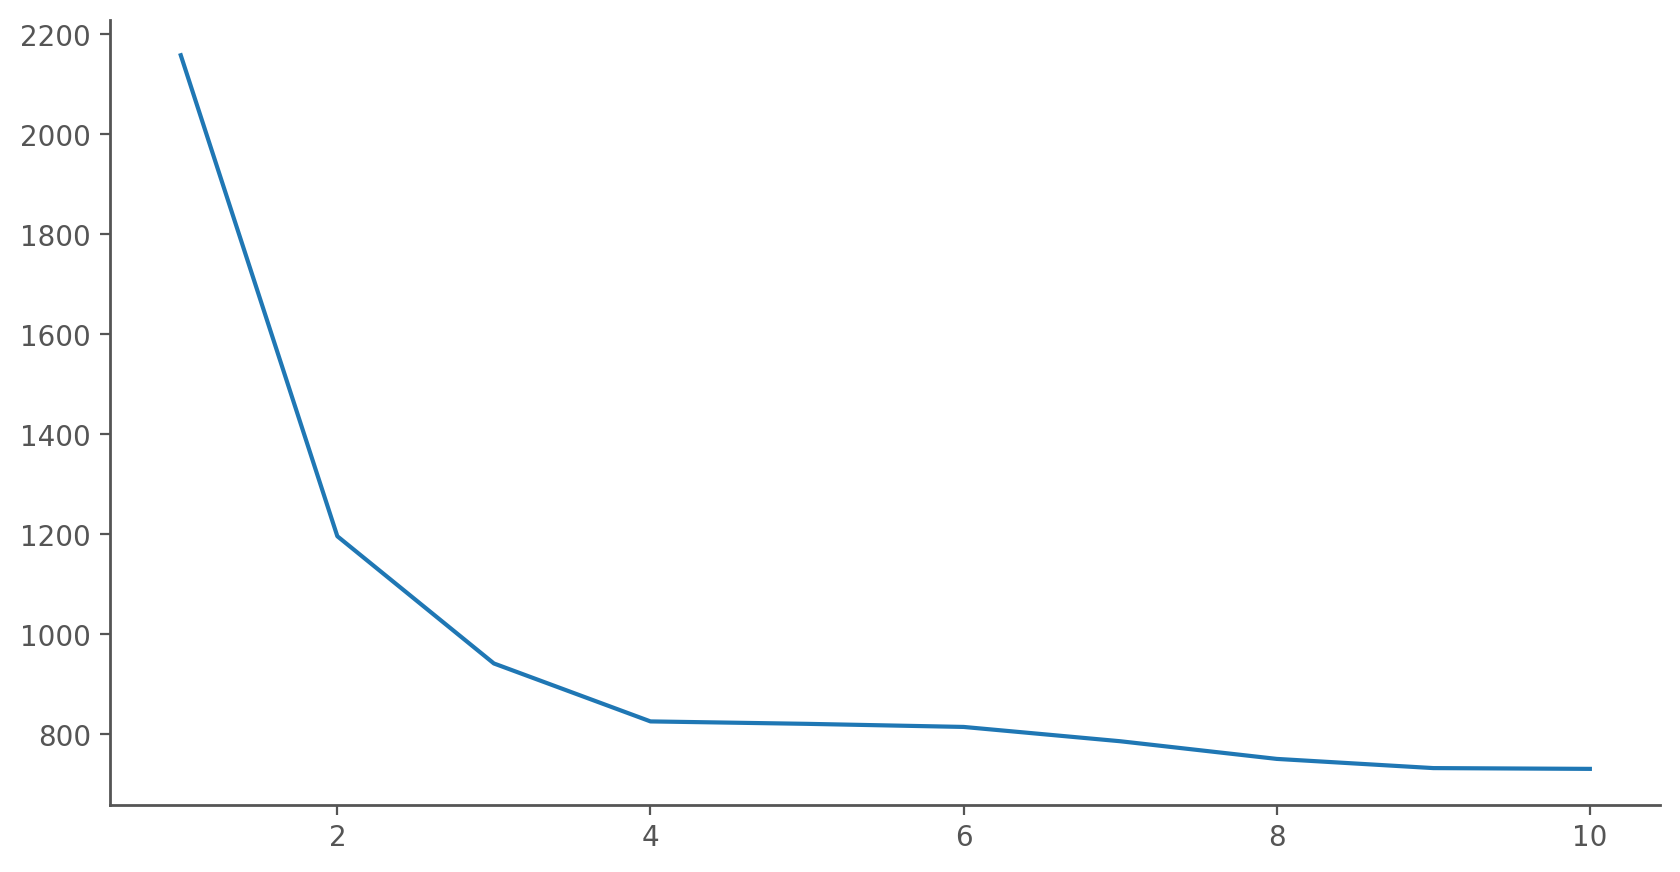

In [10]:
from sklearn.neighbors import KNeighborsRegressor

mse = []
for k in range(1,11):
    knr = KNeighborsRegressor(k)
    knr.fit(X_train, y_train)
    y_pred = knr.predict(X_test)
    mse.append(mean_squared_error(y_test, y_pred))

plt.plot(range(1,11), mse);

Lalu, jika diberikan Pokemon baru dengan nilai `Attack` 250, kira-kira berapa nilai `Defense` yang akan dihasilkan dari algoritma 1-NN?

## K-Means

Berbeda dengan k-Nearest Neighbours, k-Means merupakan algoritma untuk _unsupervised learning_, dalam hal ini adalah untuk tugas _clustering_. Dalam _clustering_, kita berusaha melihat subpopulasi dalam data dengan melihat kesamaan dari elemen di tiap subpopulasi tersebut.

Idenya adalah dengan menggunakan **centroids** atau titik-titik pusat yang mendefinisikan klaster-klaster yang ada. Tiap _centroid_ merupakan representasi dari nilai rata-rata dari objek yang masuk ke dalam klaster tersebut.

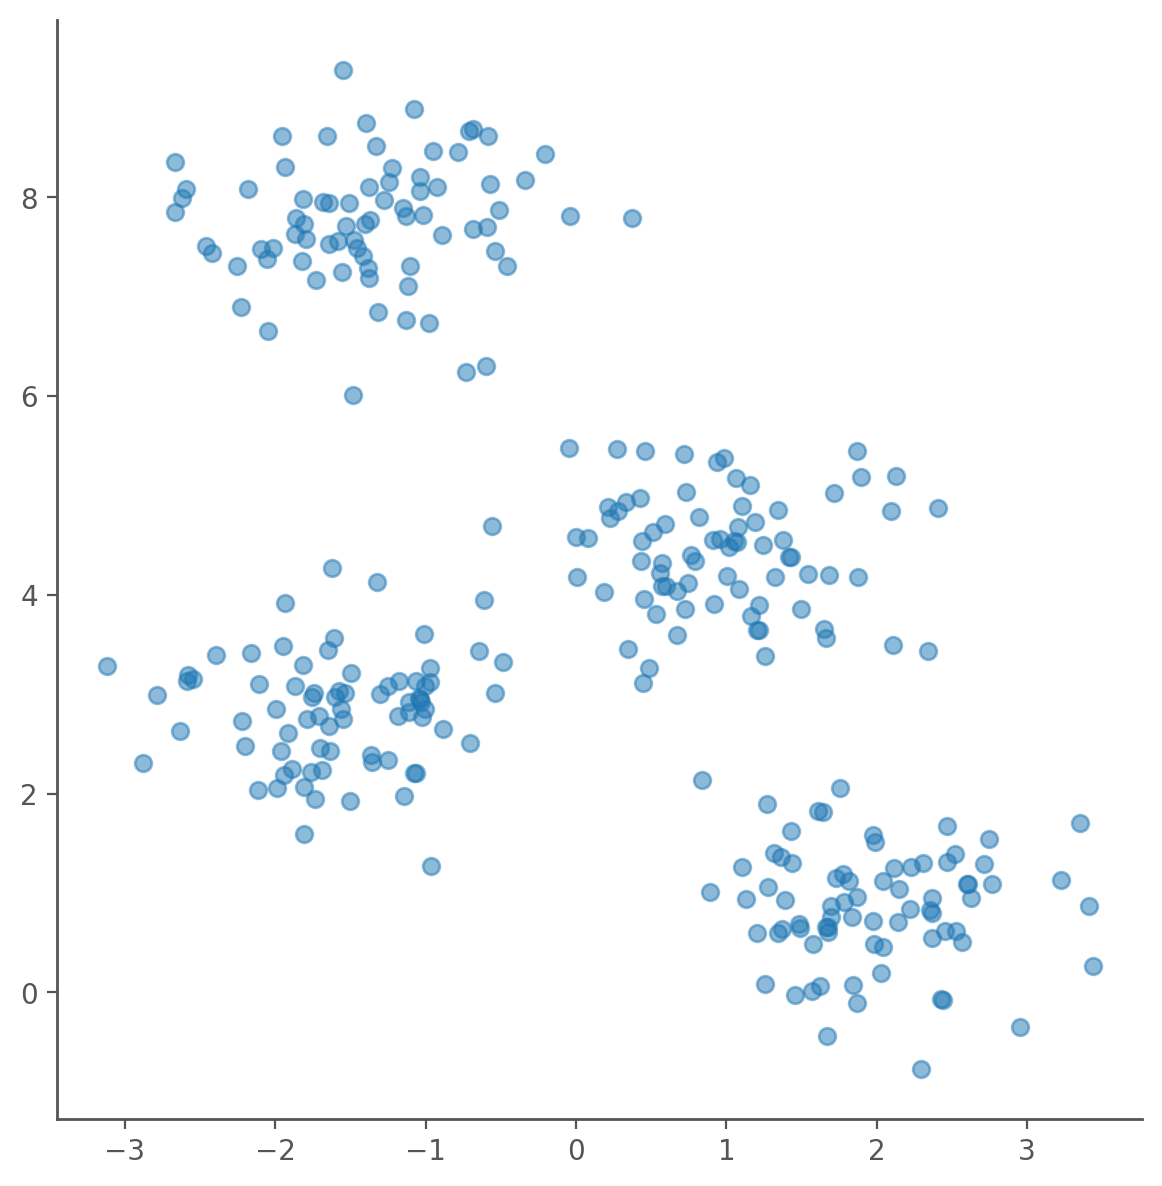

In [11]:
# Kode dari http://nbviewer.jupyter.org/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.11-K-Means.ipynb
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)

fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(X[:,0], X[:,1], alpha=.5)
plt.show()

Dalam gambar di bawah, setiap warna mewakili satu klaster. Tanda silang di gambar tersebut menunjukkan letak _centroids_-nya.

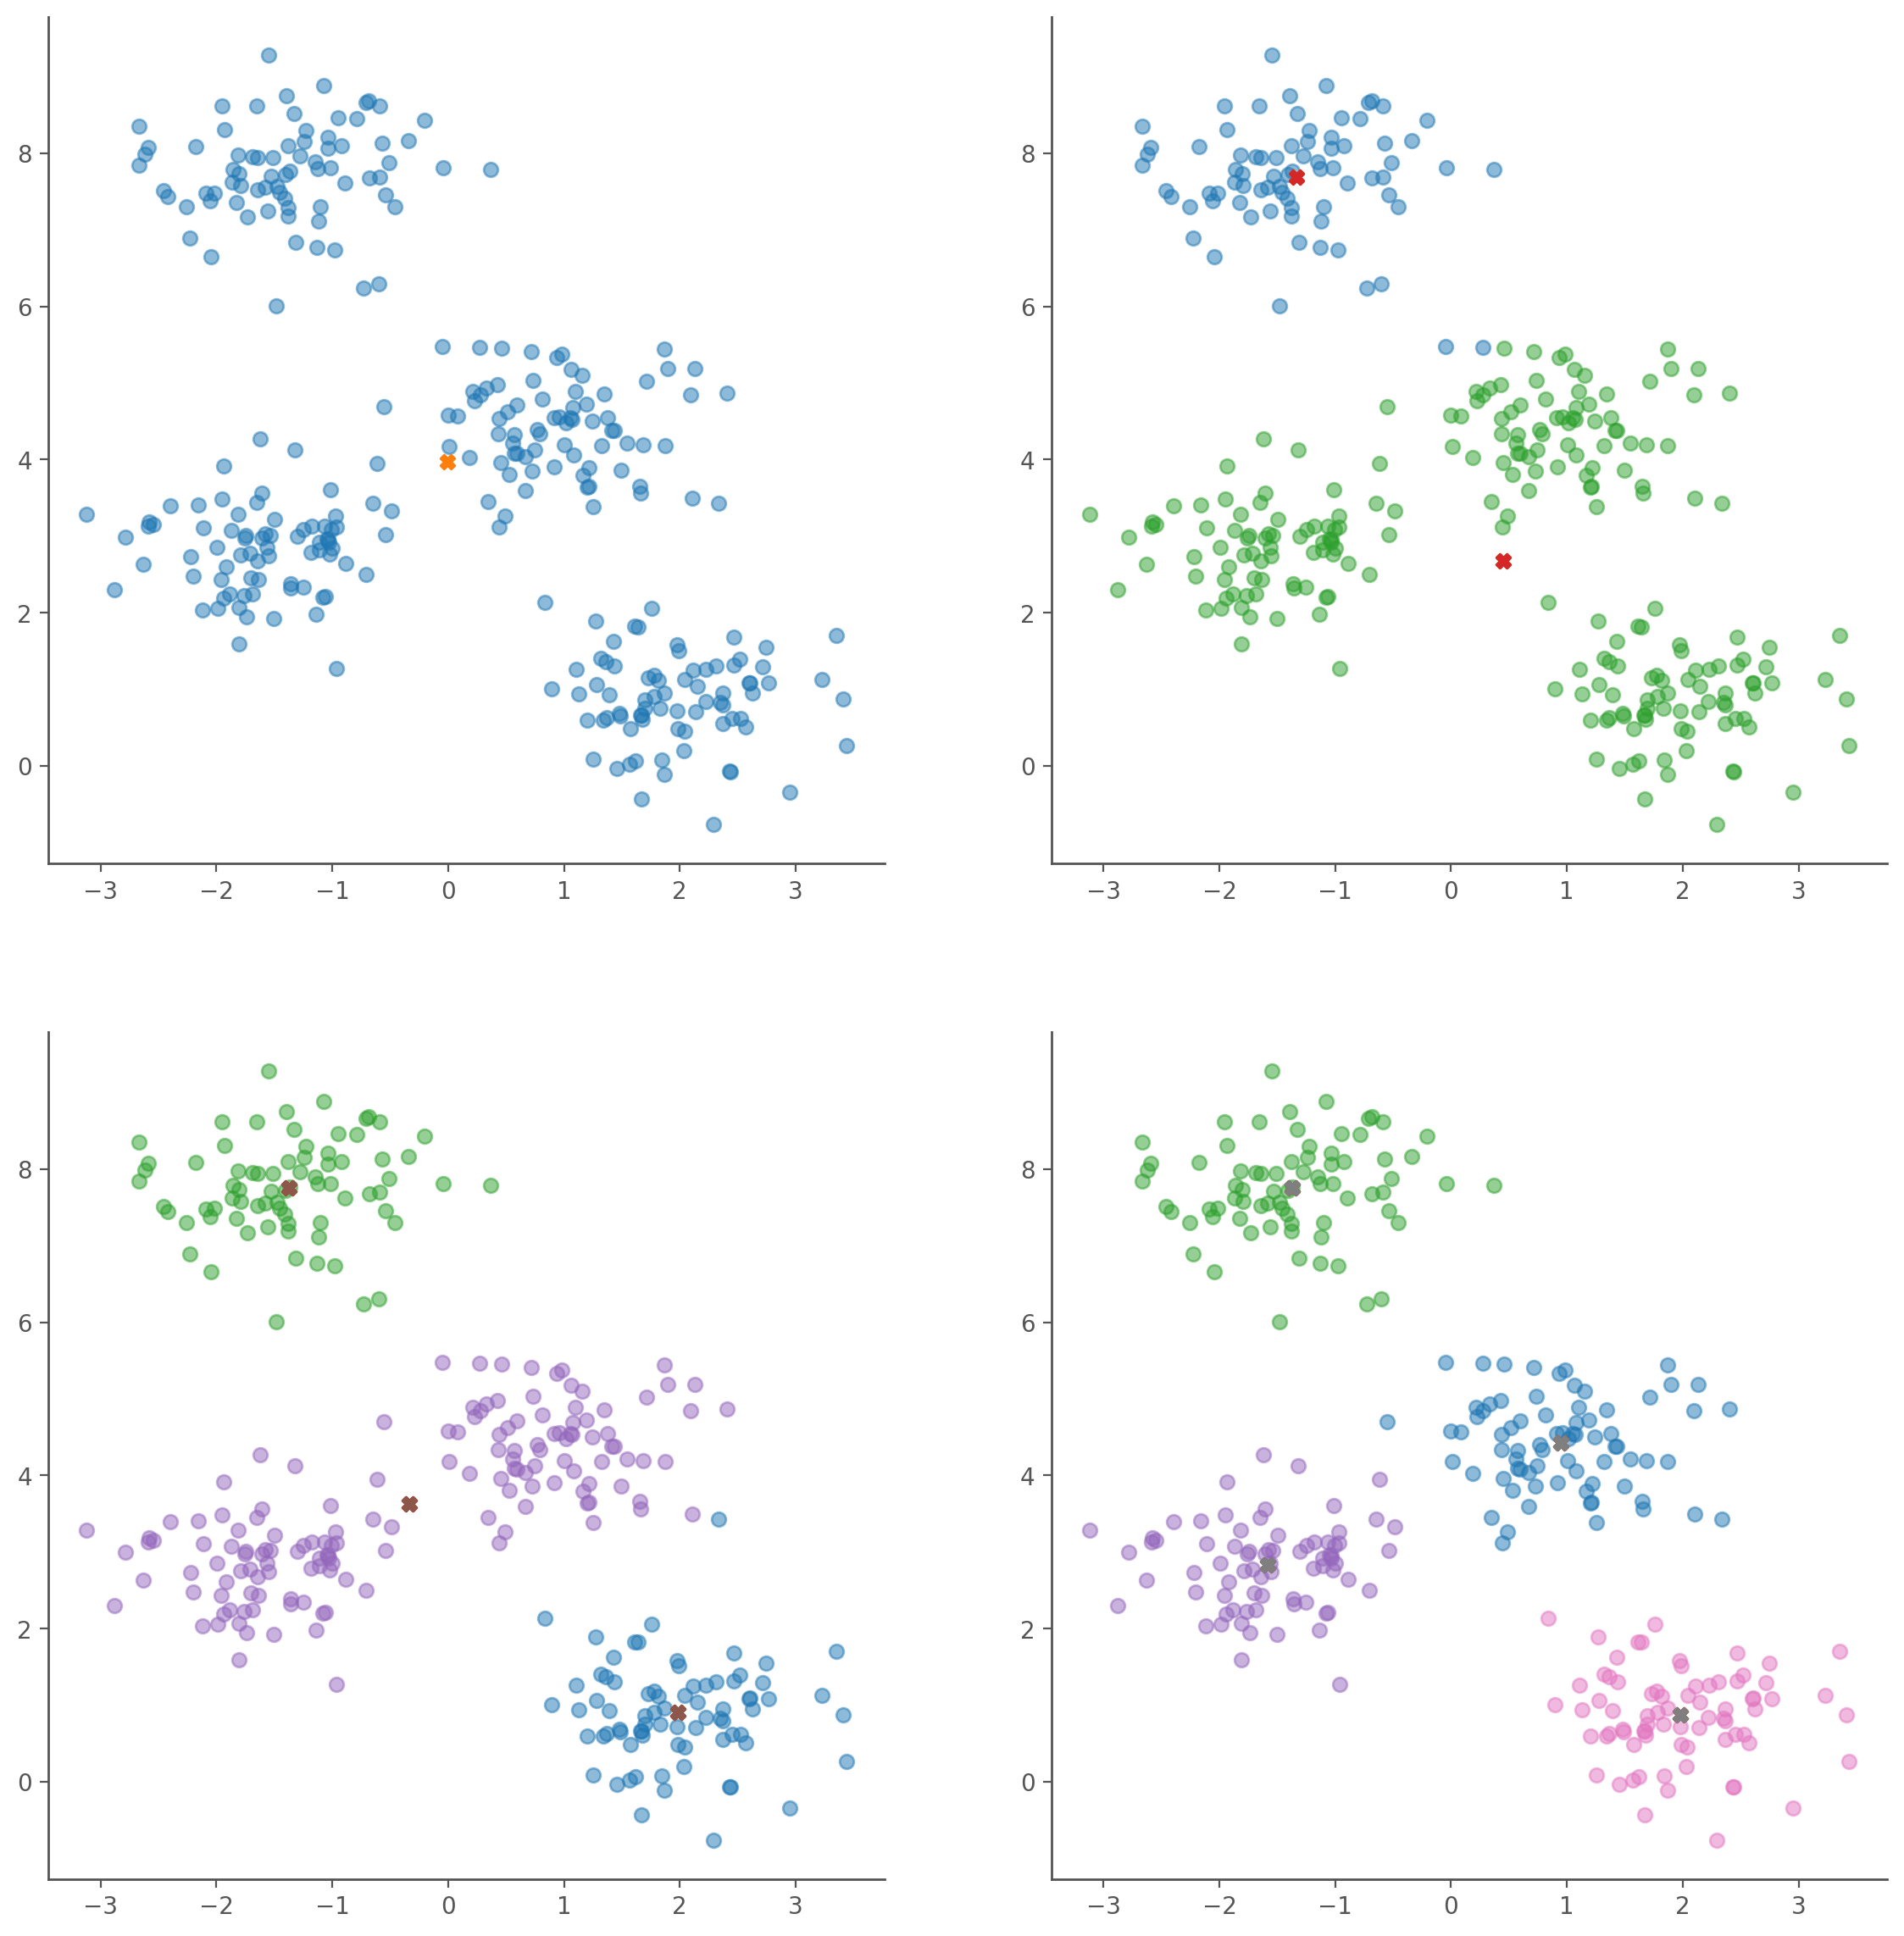

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(14,14))

for ax, n in zip(axes.flatten(), range(4)):
    kmeans = KMeans(n_clusters=n+1)
    kmeans.fit(X)

    for label in np.unique(kmeans.labels_):
        ax.scatter(
            X[np.where(kmeans.labels_ == label),0],
            X[np.where(kmeans.labels_ == label),1],
            alpha=.5
        )
        centers = kmeans.cluster_centers_
        ax.scatter(centers[:,0], centers[:,1], marker='X')

Pertanyaannya adalah bagaimana cara menentukan nilai $k$?

Ada beberapa cara:

1. Gunakan label kelas, e.g. 10 untuk MNIST
2. Gunakan V atau _inertia_ atau jarak agregat intraklaster (total jarak antara tiap data dalam suatu klaster dengan _centroid_-nya) $$V = \sum_{j} \sum_{x_i \rightarrow c_j} D(c_j, x_i)^2$$ lalu gunakan _elbow method_ (saat turunan curam berubah menjadi landai paling ekstrem)

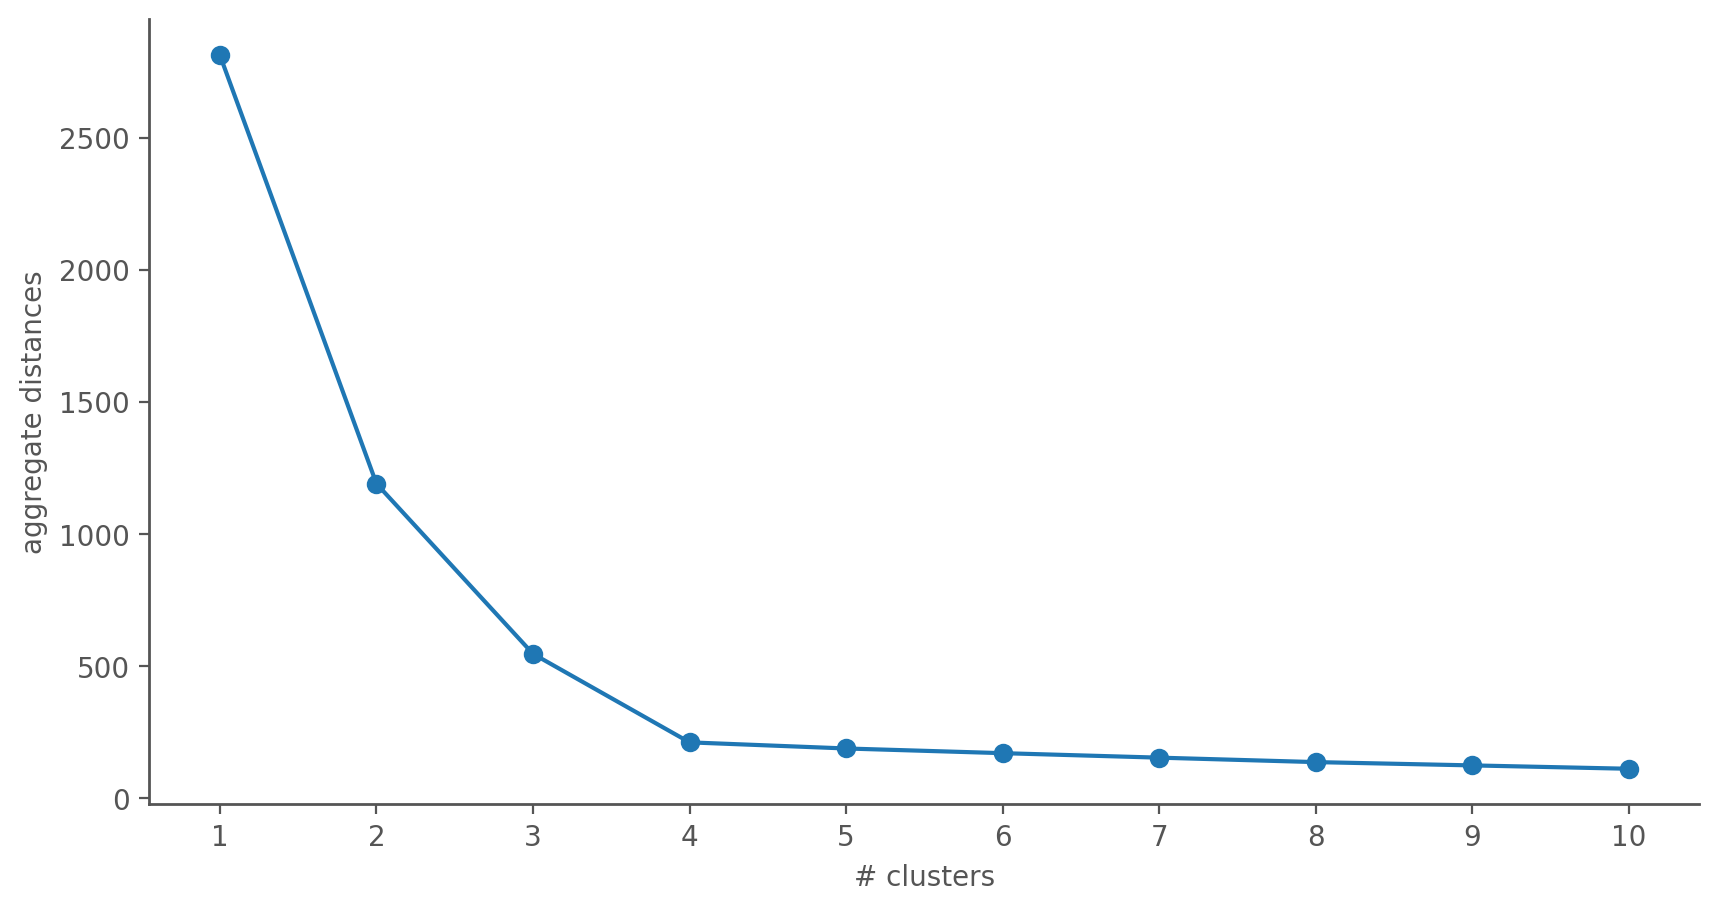

In [13]:
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)

v = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X)
    v.append(kmeans.inertia_)

plt.plot(range(1,11), v, 'o-')
plt.xticks(range(1,11), range(1,11))
plt.xlabel('# clusters')
plt.ylabel('aggregate distances')
plt.show()

Jika dilihat menggunakan *scree plot*, perubahan kecuraman yang paling drastis ada pada jumlah klaster 4, yang sebetulnya sama seperti nilai parameter `centers` dari fungsi `make_blobs()`.

Dalam kasus dataset Pokemon yang telah diberikan di atas, apakah kita bisa membedakan klaster antara Pokemon legendaris dan Pokemon biasa?

In [14]:
# Kode Anda di sini

In [15]:
%load_ext watermark
%watermark --iversions

numpy     : 1.19.2
matplotlib: 3.2.1
seaborn   : 0.10.0
pandas    : 1.1.2

